In [1]:
# importing

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Math, Latex, HTML, clear_output
from scipy import optimize

# set plot text soze
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [2]:
import seaborn as sns
sns.set_style('whitegrid')

# 1.Preparation 

## 1.1 Parameters for model 

In [3]:
N_eig = 15

In [4]:
# eigenvalues = np.load('eigenvalues/old_points.npy')
# for i in range(len(eigenvalues)):
#     if(eigenvalues[i].imag>=0):
#         print(eigenvalues[i])

#x_eig  = np.random.random(N_eig)*(-5)
#y_eig = np.random.random(N_eig)*(6)
#eigenvalues = x_eig +1j*y_eig
#np.save('new_eigenvalues', eigenvalues)
eigenvalues = np.load('lab2_data/new_eigenvalues.npy')
print(list(eigenvalues))

[(-4.0634477007783438+5.449253669660056j), (-2.3812598117215655+4.5727767454056627j), (-2.0818544666390366+3.338904772165459j), (-4.1600706157232645+0.59493492717025109j), (-0.44738644977382724+4.3253659298876048j), (-1.7087487863145079+3.1725557135407749j), (-2.2223747795561066+4.2248865061699155j), (-0.77799086684856189+5.0142852345559108j), (-0.38459864630598639+0.49380209829310284j), (-3.2997638501510886+1.9383956356352221j), (-2.8298397772329404+5.9989950235578391j), (-0.40125993272094096+5.7801192947621853j), (-3.0819422932146487+1.1734437788363288j), (-0.49678682964610532+0.35221140996145817j), (-4.318565307036585+4.1777408620659653j)]


In [5]:
#fc&fs
fc = np.ones(N_eig)
fs = np.ones(N_eig)

[]

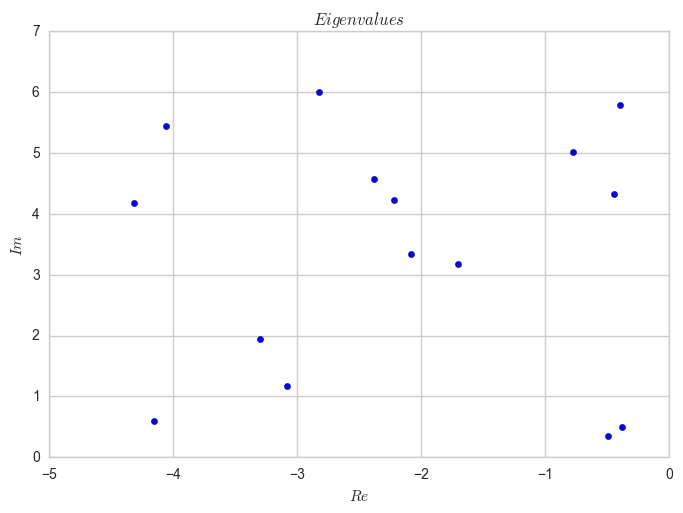

In [6]:
#plot eigenvalues

fig1, axes1 = plt.subplots()

axes1.scatter(eigenvalues.real, eigenvalues.imag)
axes1.set_xlabel('$Re$')
axes1.set_ylabel('$Im$')
axes1.set_title('$Eigenvalues$')
axes1.grid(True)

plt.plot()

## 1.2 Generate Y

$$y_k=\sum_{q=1}^{k-1} h_{k-j}u_j,$$
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1)\right)$$,
<center>$\rho_p=\sqrt{\alpha_p^2+\beta_p^2}$,
$\omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$,
$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$,
$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

We set $f_q^c=1$, $f_q^c=1$.

In [7]:
def y_cont(t, eigen, f_c, f_s):
    """continious impulse response"""
    res = 0
    for i in range(N_eig):
        res += (f_c[i]*np.cos(eigen[i].imag*t)+f_s[i]*np.sin(eigen[i].imag*t))*np.exp(eigen[i].real*t)
    return res

[]

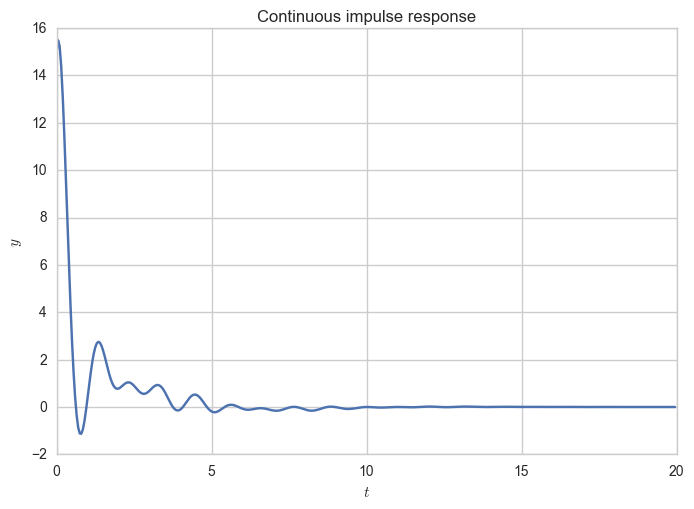

In [8]:
t = np.arange(0, 20, 0.05)
y_c = list(map(lambda x: y_cont(x, eigenvalues, fc, fs), t))

fig2, axes2 = plt.subplots()

axes2.plot(t, y_c)
axes2.set_xlabel('$t$')
axes2.set_ylabel('$y$')
axes2.set_title('Continuous impulse response')

plt.plot()

In [9]:
Eps = 0.5 #0.01 - 0.05    *max(y)

In [10]:
T = 19

In [11]:
delta = 0.1

## 1.3 Generate error

In [12]:
def norm_error(eps, n):
    error = []
    for i in range(n):
        a = np.random.normal(scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(scale=eps/3)
        error.append(a)
    return np.array(error)

In [13]:
def uniform_error(eps, n):
    return np.random.uniform(-eps, eps, size=n)

In [14]:
def two_peaks_error(eps, n):
    error = []
    for i in range(int(n/2)):
        a = np.random.normal(loc=-0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=-0.2, scale=eps/3)
        error.append(a)
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    if len(error)<n:
        a = np.random.normal(loc=0.2, scale=eps/3)
        while abs(a)>eps:
            a = np.random.normal(loc=0.2, scale=eps/3)
        error.append(a)
    return np.array(error)

## 1.4 Generate parameters

<center>$\alpha_p=e^{\lambda_p\Delta}\cos\gamma_p\Delta$</center> 
<center>$\beta_p=e^{\lambda_p\Delta}\sin\gamma_p\Delta$</center>

In [15]:
def gen_alpha_beta(delta):
    alpha = [np.exp(el.real*delta)*np.cos(el.imag*delta) for el in eigenvalues]
    beta = [np.exp(el.real*delta)*np.sin(el.imag*delta) for el in eigenvalues]
    return np.array(alpha), np.array(beta)

In [16]:
N = int(T/delta)

In [17]:
alpha, beta = gen_alpha_beta(delta)

<center>$\rho_p=\sqrt{\alpha_p^2+\beta_p^2}$, $\omega_p=arccos\frac{\alpha_p}{\sqrt{\alpha_p^2+\beta_p^2}}$ </center>



---
$$y_k=\sum_{q=1}^{k-1} h_{k-j}u_j,$$
---
$$h_k=\sum_{p=1}^P \left(\rho_p^k (f_q^c\cos\omega_p(k-1)+f_q^s\sin\omega_p(k-1))\right)$$
---

In [18]:
def gen_realy_u_h(delta, N, alpha, beta):
    rho = [np.sqrt(alpha[i]**2+beta[i]**2) for i in range(len(alpha))]
    omega = [np.arccos(alpha[i]/rho[i]) for i in range(len(alpha))]
    #print(len(rho), len(omega))
    h = [sum([rho[j]**i*(fc[j]*np.cos(omega[j]*i)+fs[j]*np.sin(omega[j]*i)) for j in range(len(omega))]) for i in range(N)]
    u = [u0, u1] + [u1**i/u0**(i-1) for i in range(2, N)]
    y = [sum([h[i-j]*u[j] for j in range(i+1)]) for i in range(N)]
    return np.array(y), np.array(u), np.array(h)

In [19]:
u0 = 1
u1 = 0.7 #0.5- 0.7

In [20]:
y_real, u, h_real = gen_realy_u_h(delta, N, alpha, beta)

In [21]:
np.random.seed(0)

In [22]:
error = norm_error(Eps, N)

In [23]:
print(error)

[ 0.29400872  0.06669287  0.163123    0.3734822   0.31125967 -0.16287965
  0.15834807 -0.0252262  -0.01720314  0.06843308  0.02400726  0.24237892
  0.12683962  0.02027917  0.07397721  0.05561239  0.24901318 -0.03419304
  0.05217795 -0.14234929 -0.4254983   0.10893643  0.1440727  -0.12369417
  0.37829244 -0.24239428  0.00762642 -0.03119731  0.2554632   0.24489313
  0.02582457  0.06302709 -0.14796429 -0.33013274 -0.05798536  0.02605816
  0.20504845  0.20039664 -0.06455447 -0.05038379 -0.17475883 -0.23666966
 -0.28437837  0.32512923 -0.08494203 -0.07301238 -0.20879923  0.12958173
 -0.26898297 -0.03545671 -0.14924443  0.06448375 -0.08513419 -0.19677203
 -0.00469704  0.07138865  0.0110862   0.05041198 -0.10572035 -0.06045686
 -0.11207674 -0.05992553 -0.13552438 -0.28771377  0.02957102 -0.06696349
 -0.27169972  0.07713038 -0.15121639  0.00865757  0.12151509  0.02149715
  0.18990011 -0.2058043   0.06705694 -0.11413502 -0.14513286 -0.09647494
 -0.05192542  0.00936089 -0.19419164  0.15013775  0

In [24]:
y = y_real+error

[]

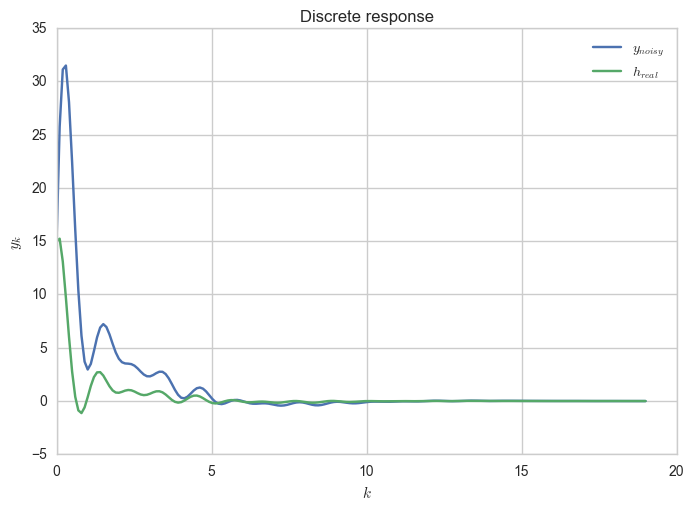

In [25]:
t = np.linspace(0, T, N)

fig3, axes3 = plt.subplots()

axes3.plot(t, y_real, label = '$y_{noisy}$')
axes3.plot(t, h_real, label = '$h_{real}$')
axes3.set_xlabel('$k$')
axes3.set_ylabel('$y_k$')
axes3.legend()
axes3.set_title('Discrete response')

plt.plot()
#mpld3.display(fig3)

In [26]:
def plot_error(error, eps,folder=''):
    """
    generate hist for error
    """
    fig4, axes4 = plt.subplots()

    weights = np.ones_like(error)/(float(len(error)))

    n, bins, patches = axes4.hist(error, 50, range = (-1.0, 1.0), facecolor='blue', weights=weights)

    axes4.set_xlabel('error')
    axes4.set_ylabel('likelihood')
    axes4.set_xlim(-1.3*eps, 1.3*eps)
    axes4.set_ylim(0, max(n)+0.05)
    axes4.set_title('Error plot')
    
    plt.plot()
    
    #mpld3.display(fig4)

In [27]:
def generate_values(eps, delta, T, gen_error, if_plot=False, folder = ''):
    """
    return: alpha, beta, y_real, u, h_real, error, y
    """
    np.random.seed(0)
    N = int(T/delta)

    alpha, beta = gen_alpha_beta(delta)
    y_real, u, h_real = gen_realy_u_h(delta, N, alpha, beta)

    #np.random.seed()
    error = gen_error(eps, N)

    y = y_real + error
    
    if if_plot:
        t = np.linspace(0, T, N)

        fig3, axes3 = plt.subplots(figsize=(16, 7))

        axes3.plot(t, y_real, label = '$y_{noisy}$')
        axes3.plot(t, h_real, label = '$h_{real}$')
        axes3.set_xlabel('$k$')
        axes3.set_ylabel('$y_k$')
        axes3.legend()
        axes3.set_title('Discrete response')
        
        fig4, axes4 = plt.subplots(figsize=(16, 7))

        axes4.plot(t, [y_real[i]/error[i] for i in range(N)])
        axes4.set_xlabel('k')
        axes4.set_ylabel('$y_k$/$error_k$')
        axes4.set_title('Signal/error (k)')
        plt.plot()
        #mpld3.display(fig3)
        
        plot_error(error, eps, folder)
    return alpha, beta, y_real, u, h_real, error, y

## 1.6 Calculating confidence intervals

In [28]:
def calc_h_central(u, y):
    """
    y0 = h0*u0
    y1 = h1*u0+h0*u1
    y2 = h2*u0+h1*u1+h0*u2
    return: h
    """
    h = [y[0]/u[0]]
    for i in range(1, len(y)):
        h.append((y[i]-sum([h[j]*u[i-j] for j in range(i)]))/u[0])
    return h

In [29]:
def calc_confidence_intervals(h_cent, eps, u0, u1):
    calc_lower = [h_cent[0]-eps/u0]
    calc_upper = [h_cent[0]+eps/u0]
    calc_lower += [h_cent[i]-eps*(1+u1/u0)/u0 for i in range(1,len(h_cent))]
    calc_upper += [h_cent[i]+eps*(1+u1/u0)/u0 for i in range(1,len(h_cent))]
    return calc_lower, calc_upper

In [30]:
def calc_percent(h_real, h_low, h_up):
    '''
    part inside true interval/all
    '''
    return str(sum([int(h_low[i]<=h_real[i] and h_up[i]>=h_real[i]) for i in range(len(h_real))])/float(len(h_real))*100)+'%'

In [31]:
def plot_res(T, delta, h_real, h_low, h_up,folder=''):
    '''
    plot true interval for h
    '''
    t = np.linspace(0, T, int(T/delta))

    fig, ax = plt.subplots(figsize=(16, 7))
    ax.plot(t, h_real, label='$h_{real}$')
    #ax.plot(t, list(map(lambda x: y_cont(x, eigenvalues, fc, fs), t)), label='$h_{cont}$')
    ax.plot(t, h_up, label = '$h_{upper}$')
    ax.plot(t, h_low, label = '$h_{low}$')
    ax.legend()
    ax.set_xlabel('k')
    ax.set_title('$h_k$')

    print("% =", calc_percent(h_real, h_low, h_up))

In [32]:
def calculate_perc_for_seq(eps, delta, T, gen_error, delta_delta = -0.01):
    perc = {}
    for i in range(10):
        delta +=delta_delta
        if delta < 0.000000001:
            break
        alpha, beta, y_real, u, h_real, error, y = generate_values(eps, delta, T, gen_error)
        h_cent = calc_h_central(u, y)
        h_low, h_up = calc_confidence_intervals(h_cent, eps, u0, u1)
        perc["{0:.3f}".format(delta)] = calc_percent(h_real, h_low, h_up)
    return perc

In [33]:
calculate_perc_for_seq(0.5, delta, T, norm_error)

{'0.010': '100.0%',
 '0.020': '100.0%',
 '0.030': '100.0%',
 '0.040': '100.0%',
 '0.050': '100.0%',
 '0.060': '100.0%',
 '0.070': '100.0%',
 '0.080': '100.0%',
 '0.090': '100.0%'}

In [34]:
def make_results(eps, delta, T, gen_error, folder=''):
    alpha, beta, y_real, u, h_real, error, y = generate_values(eps, delta, T, gen_error, if_plot=True, folder=folder)
    h_cent = calc_h_central(u, y)
    h_low, h_up = calc_confidence_intervals(h_cent, eps, u0, u1)
    plot_res(T, delta, h_real, h_low, h_up, folder)
    return y, u, h_cent, h_low, h_up

% = 100.0%


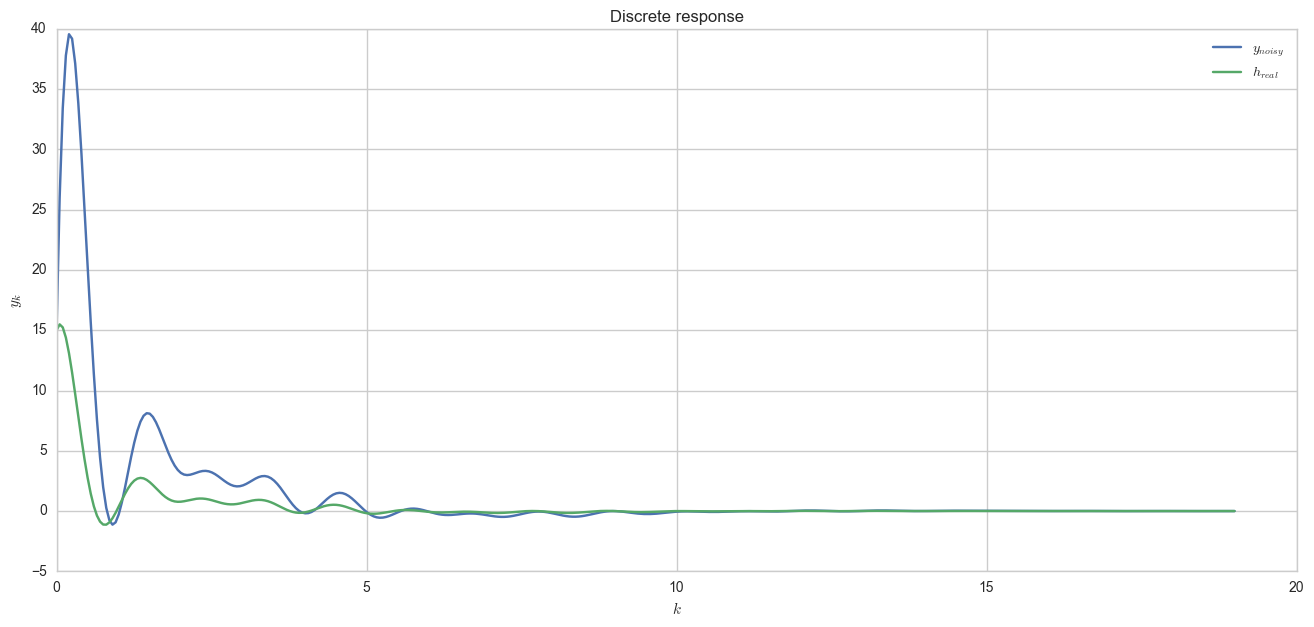

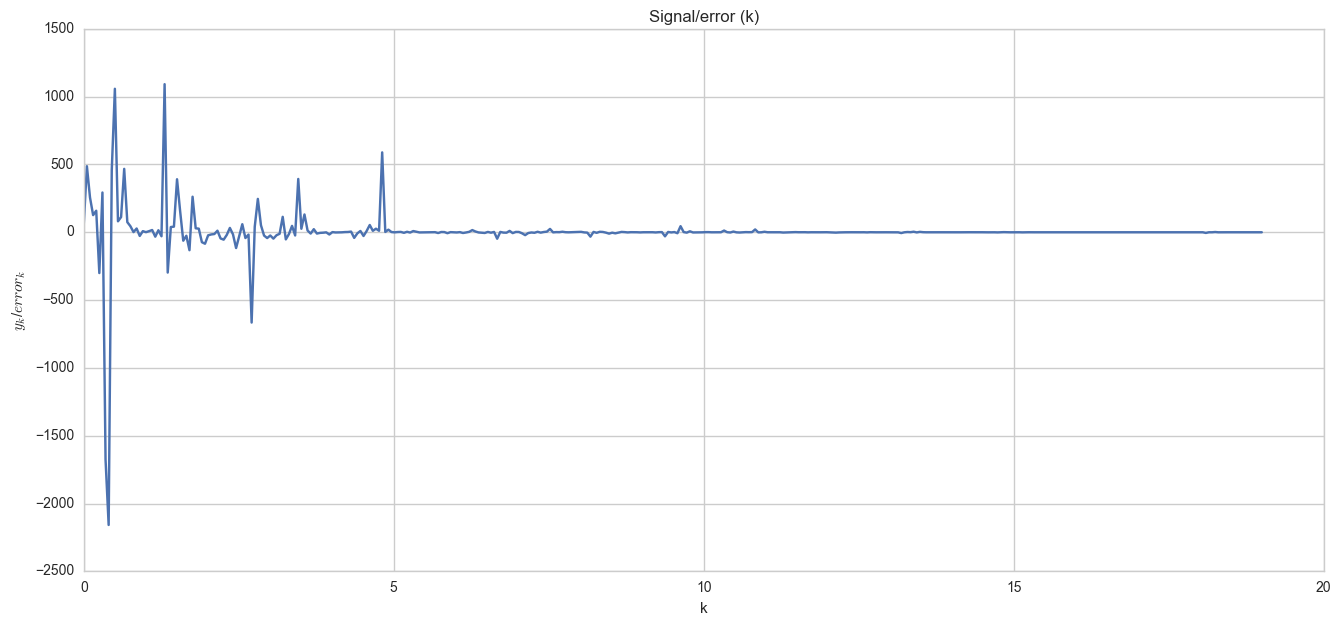

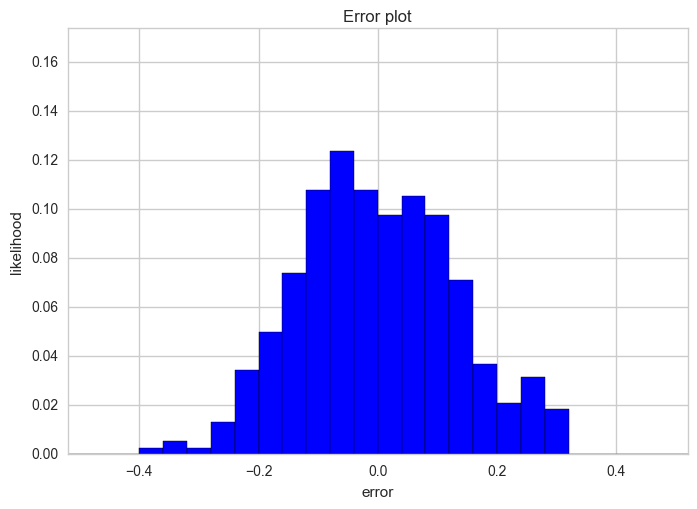

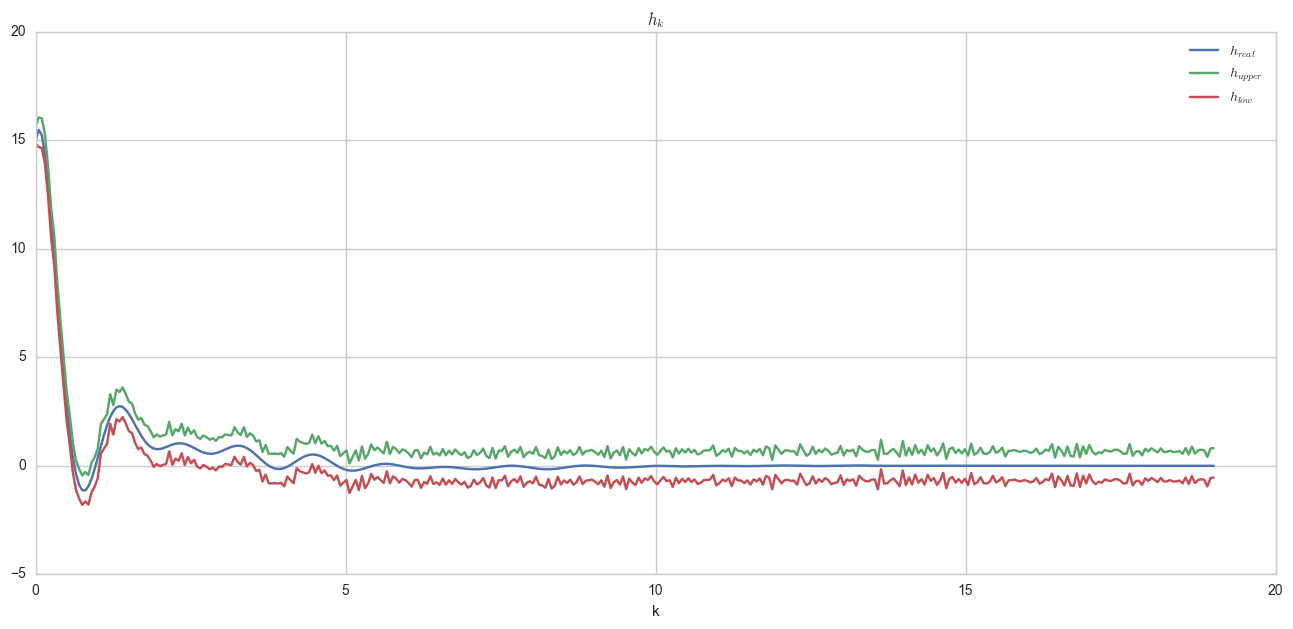

In [35]:
y, u, h_cent, h_low, h_up = make_results(0.4, 0.05, 19, norm_error)

In [36]:
def output(eps, N, generator_error,folder=''):
    np.random.seed(0)
    error = generator_error(eps, N)
    y = y_real+error
    t = np.linspace(0, T, N)

    fig3, axes3 = plt.subplots()

    axes3.plot(t, y_real, label = '$y_{noisy}$')
    axes3.plot(t, h_real, label = '$h_{real}$')
    axes3.set_xlabel('$k$')
    axes3.set_ylabel('$y_k$')
    axes3.legend()
    axes3.set_title('Discrete response')

    plt.plot()
    
    perc_seq = calculate_perc_for_seq(0.5, delta, T, generator_error)
    print("perc_seq:\n", perc_seq)
    
    y, u, h_cent, h_low, h_up = make_results(0.4, 0.05, 19, generator_error,folder)
    
    
    
    

perc_seq:
 {'0.030': '100.0%', '0.010': '100.0%', '0.040': '100.0%', '0.070': '100.0%', '0.090': '100.0%', '0.060': '100.0%', '0.020': '100.0%', '0.050': '100.0%', '0.080': '100.0%'}
% = 100.0%


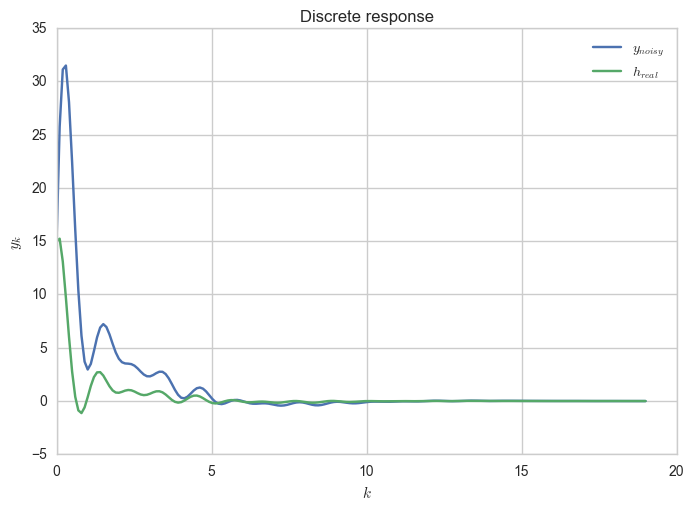

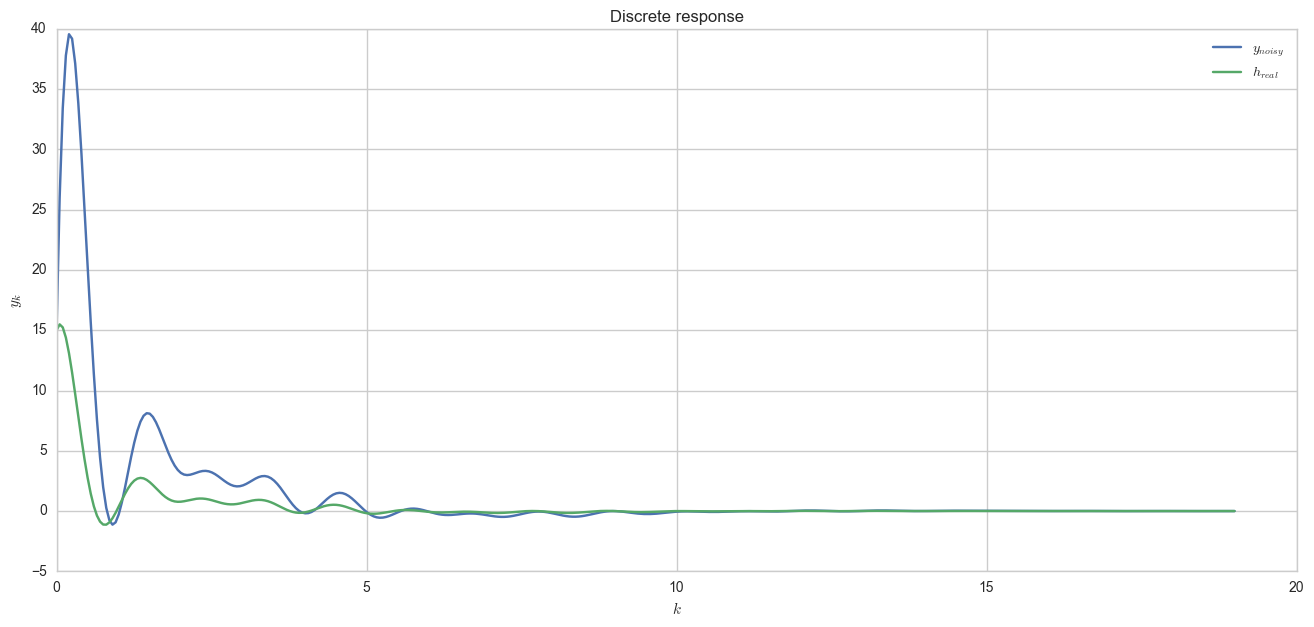

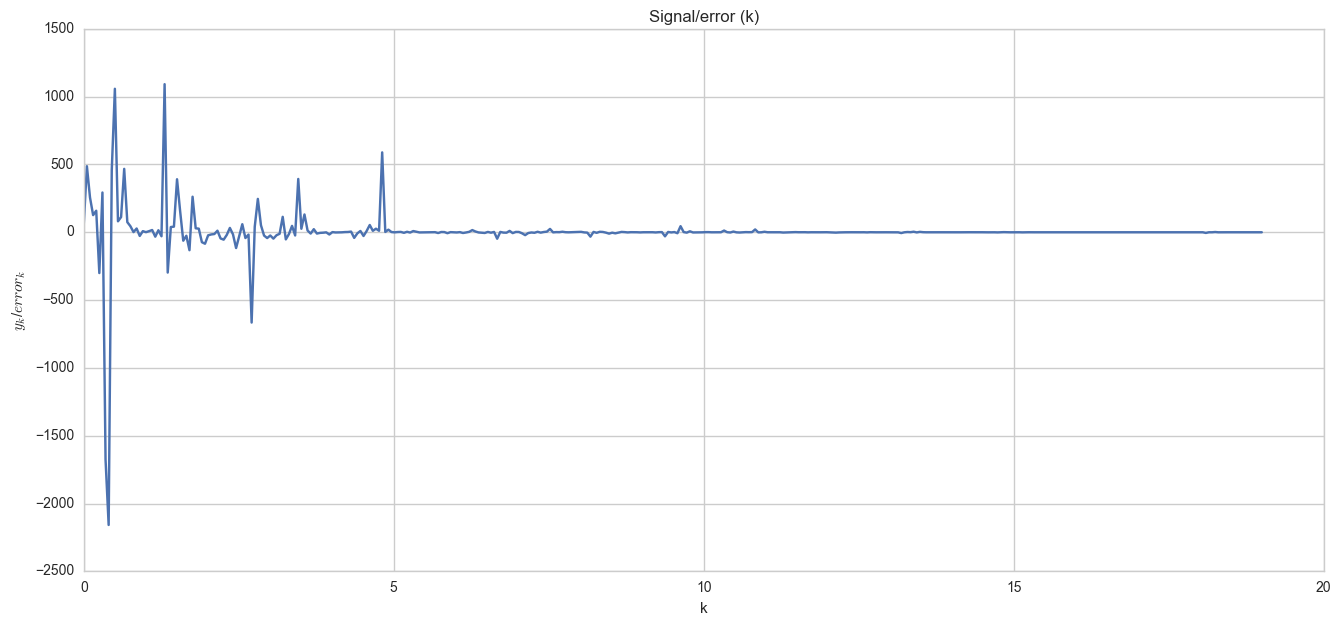

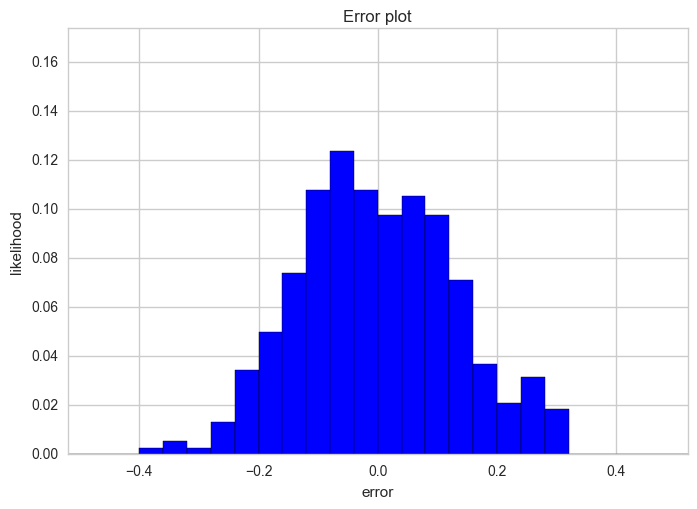

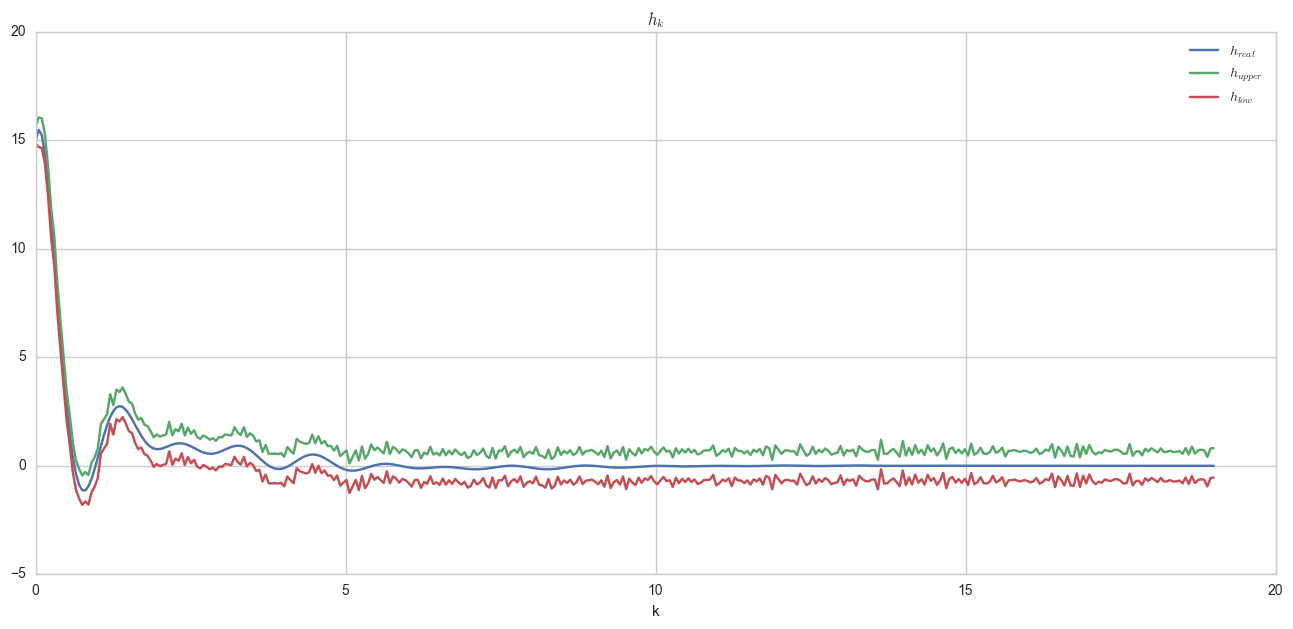

In [37]:
output(Eps, N, norm_error,'norm/')

perc_seq:
 {'0.030': '100.0%', '0.010': '100.0%', '0.040': '100.0%', '0.070': '100.0%', '0.090': '100.0%', '0.060': '100.0%', '0.020': '100.0%', '0.050': '100.0%', '0.080': '100.0%'}
% = 100.0%


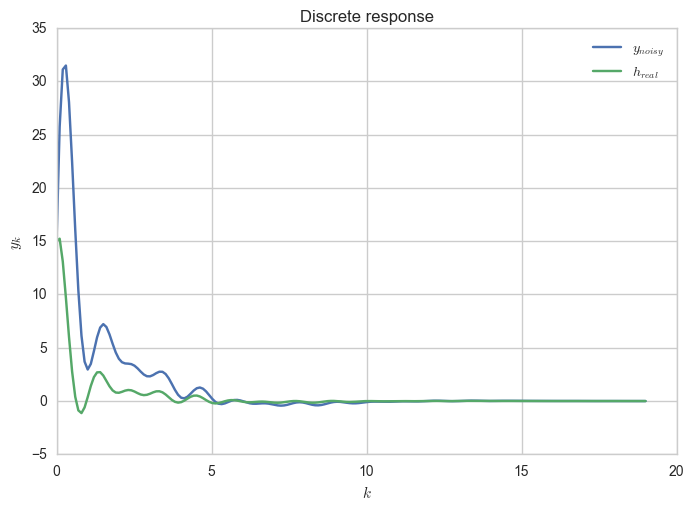

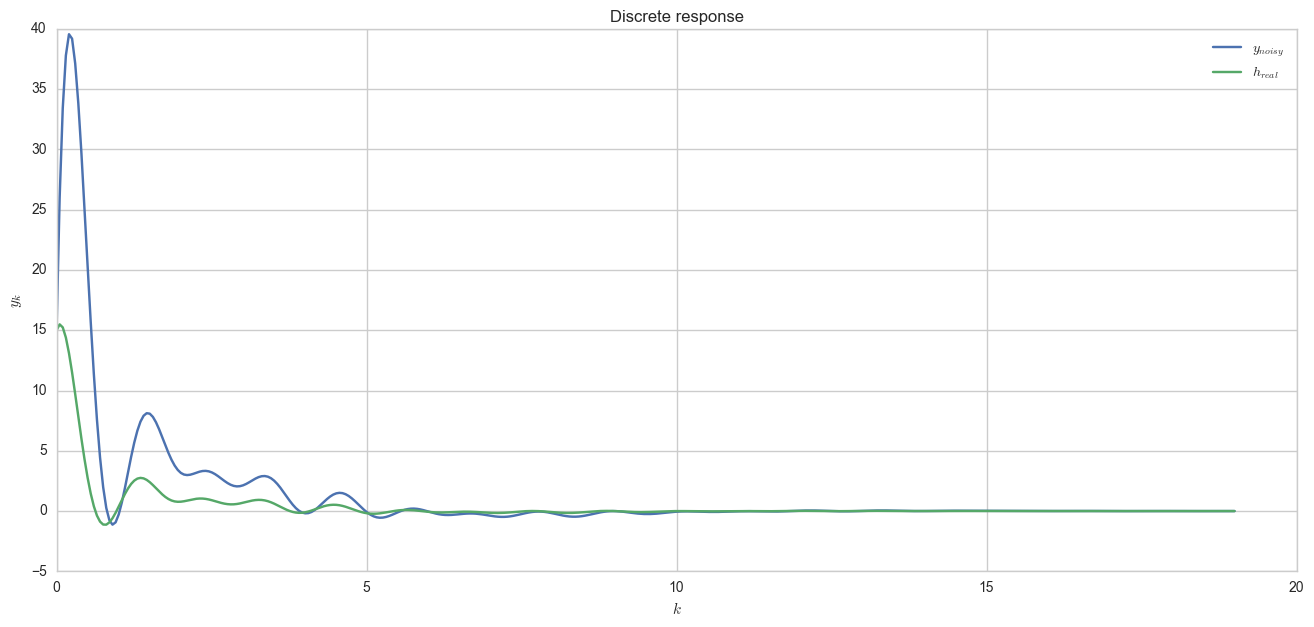

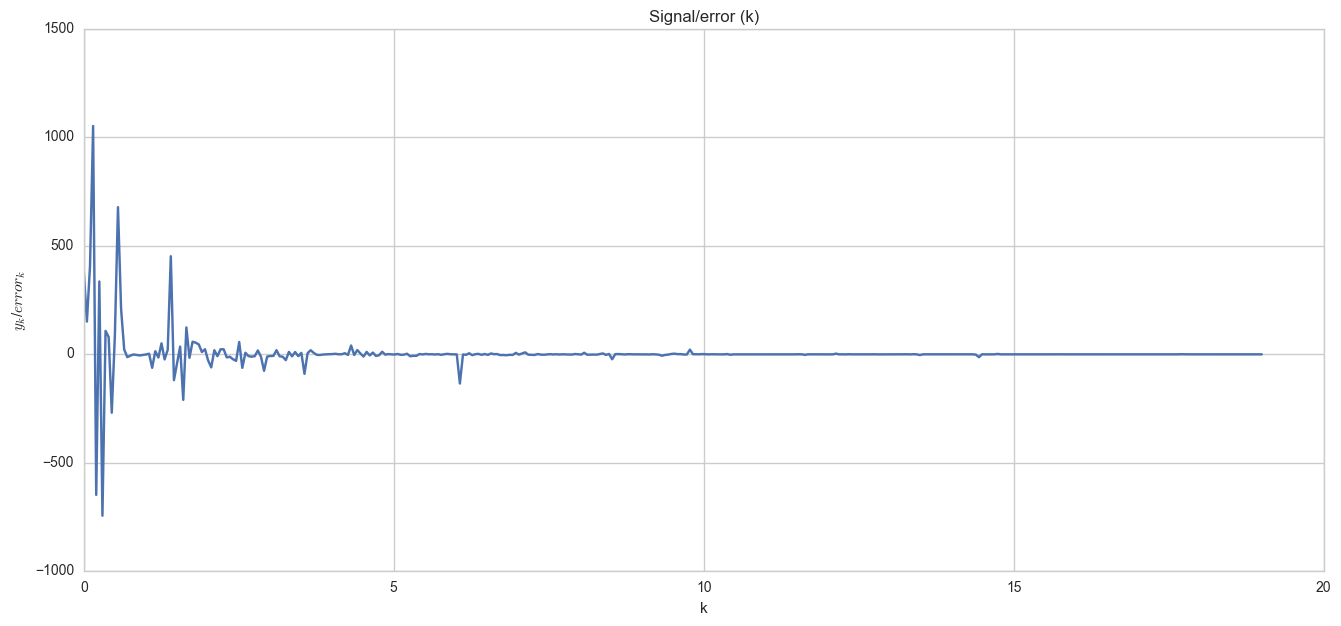

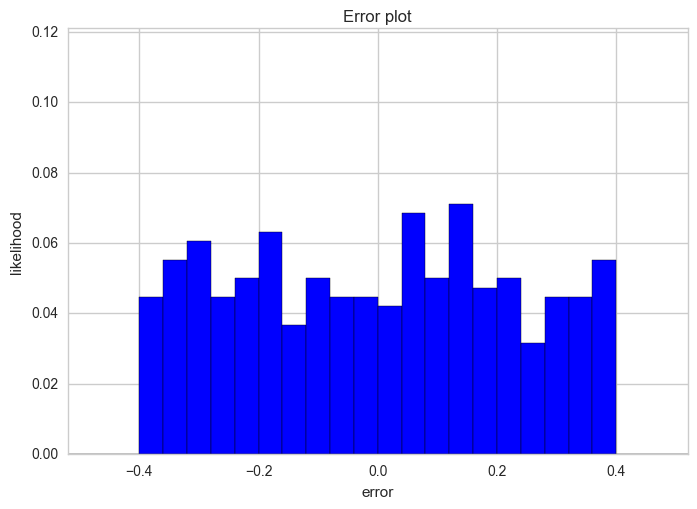

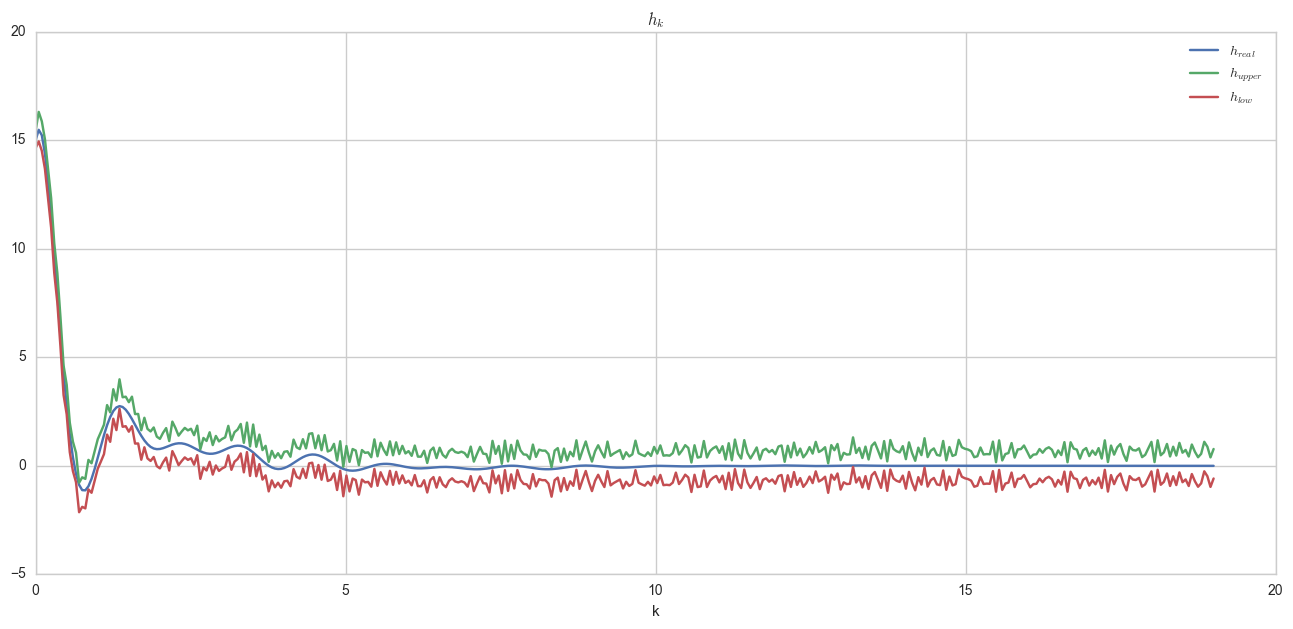

In [38]:
output(Eps, N,uniform_error ,'uniform/')

perc_seq:
 {'0.030': '100.0%', '0.010': '100.0%', '0.040': '100.0%', '0.070': '100.0%', '0.090': '100.0%', '0.060': '100.0%', '0.020': '100.0%', '0.050': '100.0%', '0.080': '100.0%'}
% = 100.0%


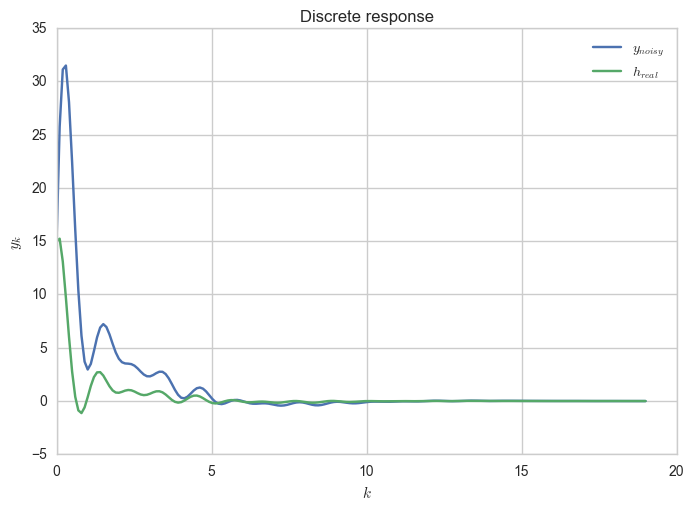

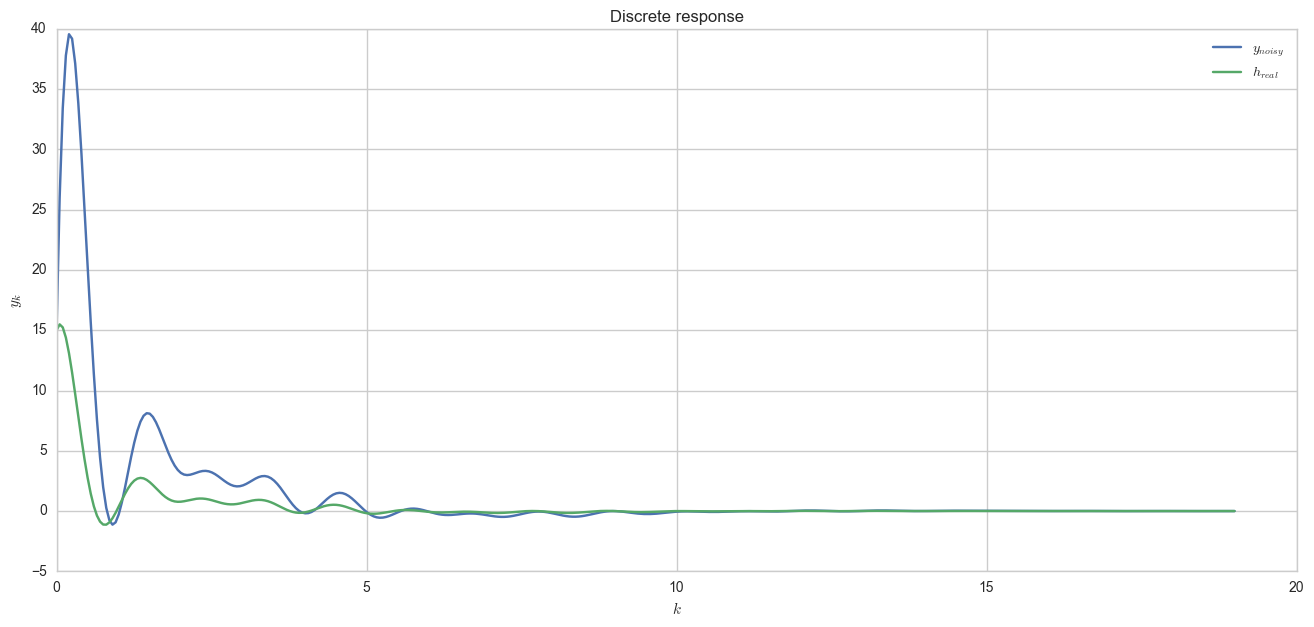

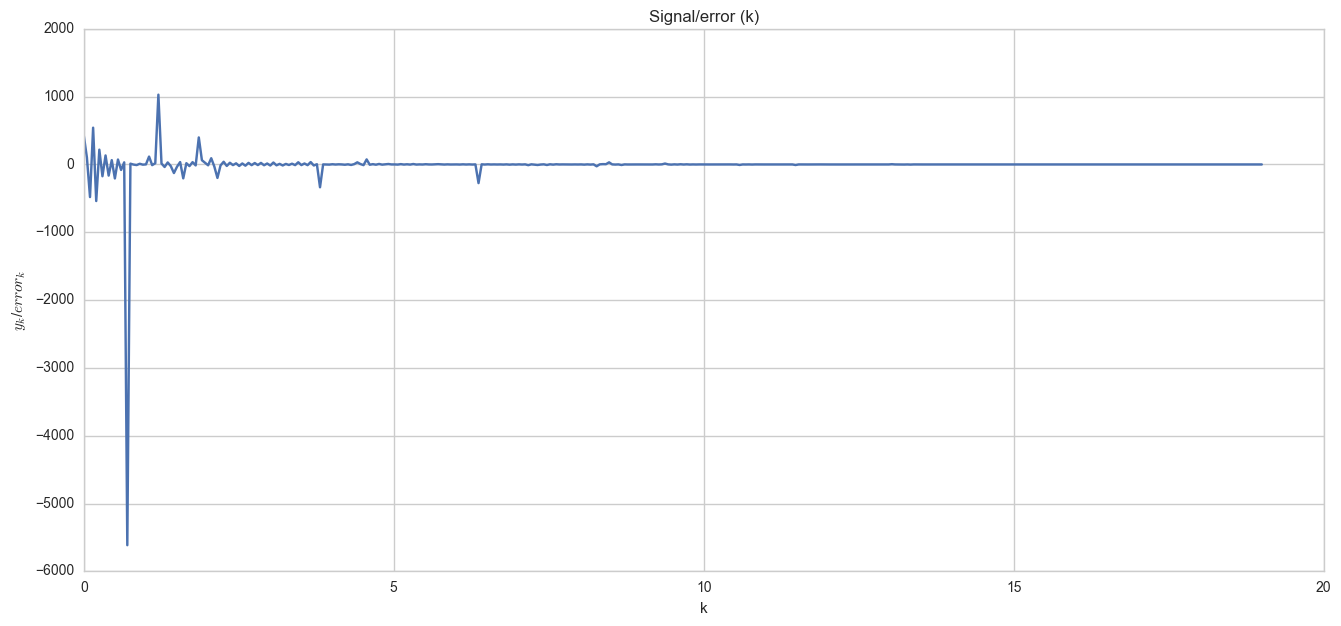

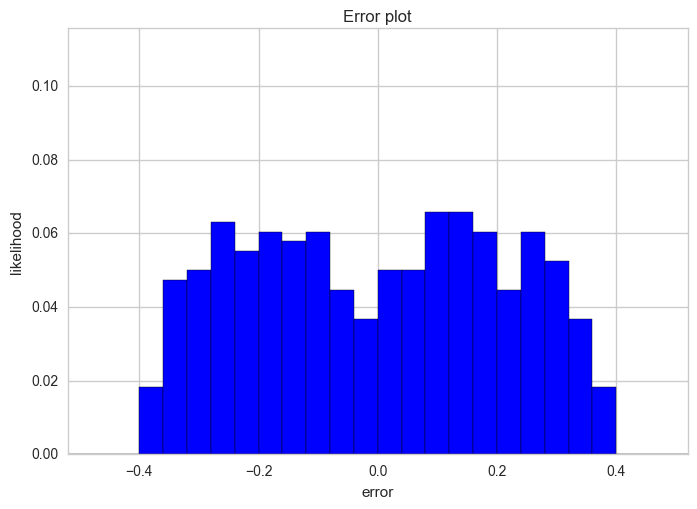

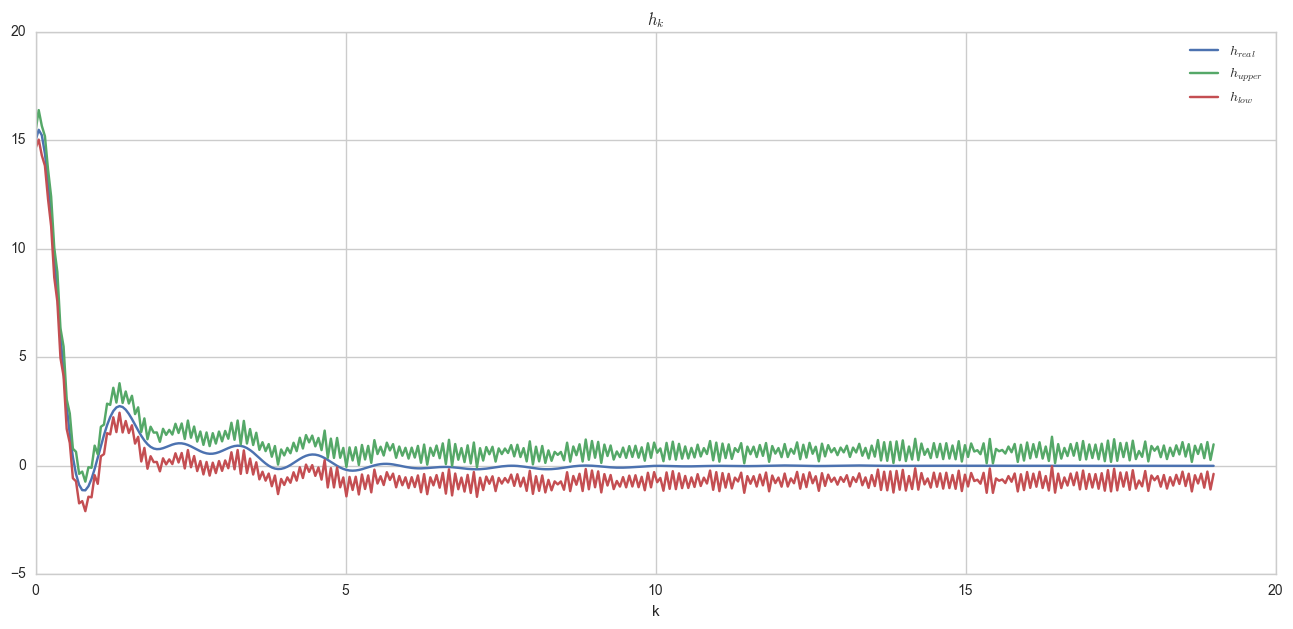

In [39]:
output(Eps, N,two_peaks_error ,'twopeaks/')

In [40]:
N

190